# Review
Hi Kushal, my name is Dmitry and I will be reviewing your project.

You can find my comments in colored markdown cells:

<div class="alert alert-success">
    If everything is done succesfully.
</div>

<div class="alert alert-warning">
    If I have some (optional) suggestions, or questions to think about, or general comments.
</div>

<div class="alert alert-danger">
    If a section requires some corrections. Work can't be accepted with red comments.
</div>

Please don't remove my comments, as it will make further review iterations much harder for me.

Feel free to reply to my comments or ask questions using the following template:

<div class="alert alert-info">
    For your comments and questions.
</div>

First of all, thank you for turning in the project! You did a great job! The project is accepted. Good luck on the next sprint!

# Project description
## Task statement

Prepare a prototype of a machine learning model for Zyfra. The company develops efficiency solutions for heavy industry.
The model should predict the amount of gold recovered from gold ore. You have the data on extraction and purification.
The model will help to optimize the production and eliminate unprofitable parameters.

Data is indexed with the date and time of acquisition (date feature). Parameters that are next to each other in terms of time are often similar.
Some parameters are not available because they were measured and/or calculated much later. That's why, some of the features that are present in the training set may be absent from the test set. The test set also doesn't contain targets.
The source dataset contains the training and test sets with all the features.
You have the raw data that was only downloaded from the warehouse. Before building the model, check the correctness of the data. For that, use our instructions.

In [ ]:
#Adding this first up to make sure we don't need to see warnings to make outputs look nice
import sys
import warnings
if not sys.warnoptions:
       warnings.simplefilter("ignore")

In [1]:
#Let us first import the relevant libraries
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score
from joblib import dump
from sklearn.metrics import mean_absolute_error
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import f1_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import recall_score
from sklearn.metrics import precision_score
from sklearn.utils import resample
from sklearn.metrics import roc_auc_score
from sklearn.metrics import make_scorer
from sklearn.utils import shuffle
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import roc_curve
import matplotlib.pyplot as plt
from sklearn.metrics import precision_recall_curve
import numpy as np
from sklearn.metrics import mean_squared_error
from scipy import stats as st
from sklearn.model_selection import cross_val_score

from sklearn.model_selection import *
from sklearn.ensemble import *
from sklearn.tree import DecisionTreeRegressor
from sklearn.linear_model import *
from sklearn.metrics import *
from sklearn.utils import shuffle
from sklearn.dummy import DummyRegressor
from sklearn.dummy import DummyClassifier

In [2]:
#Now, let us load the data
train = pd.read_csv('https://code.s3.yandex.net/datasets/gold_recovery_train.csv')

test = pd.read_csv('https://code.s3.yandex.net/datasets/gold_recovery_test.csv')

full = pd.read_csv('https://code.s3.yandex.net/datasets/gold_recovery_full.csv')


## Prepare the data
### Open the files and look into the data.

In [3]:
#All helper functions are created in this code chunk to keep the rest of the report neat

#This function gives us a premilinary glimpse into the data
def inspect_data(df):
    print(df.head())
    print(df.isna().sum())
    print(df.info())
    print(df.describe())

#This function prints the names of the column that have the string that has been passed as an argument and returns the 
#dataframe with only the columns that have those strings in it's name.
def cols_with_str(df, string):
    cols = [col for col in df.columns if string in col]
    print(list(df[cols]))
    return df[cols]

#This function calculates recovery. You need to provide the string names of the columns used for calculation.
#Function returns the column with NAs dropped.
def recover_calculation(df,c,f,t):
    cal = 100 * (df[c] * (df[f] - df[t])) / (df[f] * (df[c] - df[t]))
    return cal

#This function removes the rows with NAs in a 'union' method so that the mae calculation can be done with columns that
#have the same number of elements. Returns a dataframe that contains both columns.
def dropna_mult(a,b):
    df = pd.DataFrame({'a':a,'b':b}).dropna()
    return df



def rougher_feed(df, metal, rougher, feed, inpu):
    
    au_rougher = cols_with_str(train,metal)
    au_rougher = cols_with_str(au_rougher,rougher)
    au_rougher = cols_with_str(au_rougher,feed)
    au_rougher = cols_with_str(au_rougher,inpu)
    #print(au_rougher)
    mean = au_rougher.mean()
    return mean[0]

def concentrate_sum(df,drop1,drop2):
    rougher_input_feed = cols_with_str(full,'rougher.input.feed')
    #print(rougher_input_feed)
    rougher_input_feed = rougher_input_feed.drop(drop1,axis=1)
    rougher_input_feed = rougher_input_feed.drop(drop2,axis=1)
    #print(rougher_input_feed.columns)
    #full[rougher_input_feed.columns].sum(1).hist(20)
    return list(df[rougher_input_feed.columns])

def smape_helper(target, predicted):
    ratio = np.divide(np.abs(target - predicted), (np.abs(target)+np.abs(predicted))/2)
    value = np.average(ratio, axis=0)
    return value

def smape(targeted,predicted):
    smape_rougher = smape_helper(targeted[target.index('rougher.output.recovery')], predicted[target.index('rougher.output.recovery')])
    smape_final = smape_helper(targeted[target.index('final.output.recovery')], predicted[target.index('final.output.recovery')])
    value = 0.25*smape_rougher + 0.75*smape_final
    return value

def lin_reg(features_train, features_test, target_train, target_test):
    scaler = StandardScaler()
    scaler.fit(features_train)
    features_train = scaler.transform(features_train)
    features_test= scaler.transform(features_test)
    lr = LinearRegression().fit(features_train,target_train)
    predicted_values = lr.predict(features_test)
    smape = cross_val_score(lr, features_train, target_train, cv=5, scoring=smape_scorer)
    print("average smape:", smape.mean())
    print('R2', lr.score(features_test, target_test))
    print('RMSE:', np.sqrt(mean_squared_error(target_test, predicted_values)))
    print('Average Volume of Predicted Reserve:',predicted_values.mean() )
    
def dec_tree_mod(features_train, features_test, target_train, target_test):
    depth_param = {'max_depth': range(6,12,2)}
    DecTreeMod = DecisionTreeRegressor(random_state=12345)
    DecTreeModOpt = GridSearchCV(DecTreeMod,depth_param, scoring=smape_scorer, cv=5)
    DecTreeModOpt.fit(features_train, target_train)
    print(DecTreeModOpt.best_estimator_)
    smape = cross_val_score(DecTreeModOpt, features_train, target_train, cv=5, scoring=smape_scorer)
    print("average smape:", smape.mean())
    DecTreeModOpt_predicted_test = DecTreeModOpt.predict(features_test)
    print('Accuracy:', DecTreeModOpt.score(features_test, target_test))

def rand_for_mod(features_train, features_test, target_train, target_test):
    param = {'n_estimators':range(1,100,20)}
    RandForestOpt = GridSearchCV(RandomForestRegressor(random_state=12345,max_depth = 9), param_grid=param,scoring=smape_scorer, cv=5, refit=True)
    RandForestOpt.fit(features_train, target_train)
    print(RandForestOpt.best_estimator_)
    smape = cross_val_score(RandForestOpt, features_train, target_train, cv=3, scoring=smape_scorer)
    print("average smape:", smape.mean())
    RandForestOpt_predicted_test = RandForestOpt.predict(features_test)
    print('Accuracy:', RandForestOpt.score(features_test, target_test))
    

def dum_reg(features_train, features_test, target_train, target_test):
    dummy = DummyRegressor(strategy='mean').fit(features_train, target_train)
    target_pred = dummy.predict(features_test)
    print('smape:', smape(target_test, target_pred))

All functions required for this report have been written in this chunk.

In [4]:
inspect_data(train)

                  date  final.output.concentrate_ag  \
0  2016-01-15 00:00:00                     6.055403   
1  2016-01-15 01:00:00                     6.029369   
2  2016-01-15 02:00:00                     6.055926   
3  2016-01-15 03:00:00                     6.047977   
4  2016-01-15 04:00:00                     6.148599   

   final.output.concentrate_pb  final.output.concentrate_sol  \
0                     9.889648                      5.507324   
1                     9.968944                      5.257781   
2                    10.213995                      5.383759   
3                     9.977019                      4.858634   
4                    10.142511                      4.939416   

   final.output.concentrate_au  final.output.recovery  final.output.tail_ag  \
0                    42.192020              70.541216             10.411962   
1                    42.701629              69.266198             10.462676   
2                    42.657501              68.

In [5]:
inspect_data(test)

                  date  primary_cleaner.input.sulfate  \
0  2016-09-01 00:59:59                     210.800909   
1  2016-09-01 01:59:59                     215.392455   
2  2016-09-01 02:59:59                     215.259946   
3  2016-09-01 03:59:59                     215.336236   
4  2016-09-01 04:59:59                     199.099327   

   primary_cleaner.input.depressant  primary_cleaner.input.feed_size  \
0                         14.993118                         8.080000   
1                         14.987471                         8.080000   
2                         12.884934                         7.786667   
3                         12.006805                         7.640000   
4                         10.682530                         7.530000   

   primary_cleaner.input.xanthate  primary_cleaner.state.floatbank8_a_air  \
0                        1.005021                             1398.981301   
1                        0.990469                             1398.777

In [6]:
inspect_data(full)

                  date  final.output.concentrate_ag  \
0  2016-01-15 00:00:00                     6.055403   
1  2016-01-15 01:00:00                     6.029369   
2  2016-01-15 02:00:00                     6.055926   
3  2016-01-15 03:00:00                     6.047977   
4  2016-01-15 04:00:00                     6.148599   

   final.output.concentrate_pb  final.output.concentrate_sol  \
0                     9.889648                      5.507324   
1                     9.968944                      5.257781   
2                    10.213995                      5.383759   
3                     9.977019                      4.858634   
4                    10.142511                      4.939416   

   final.output.concentrate_au  final.output.recovery  final.output.tail_ag  \
0                    42.192020              70.541216             10.411962   
1                    42.701629              69.266198             10.462676   
2                    42.657501              68.

<div class="alert alert-success">
    Alright, you loaded the data and had a look at it!
</div>

These are some huge datasets. There are many possible issues and existence of null values. Let's deal with them as needed based on tasks that come.
### Check that recovery is calculated correctly. Using the training set, calculate recovery for the rougher.output.recovery feature. Find the MAE between your calculations and the feature values. Provide findings.

In [7]:
rougher_train = cols_with_str(train,'rougher')
rougher_train

['rougher.calculation.sulfate_to_au_concentrate', 'rougher.calculation.floatbank10_sulfate_to_au_feed', 'rougher.calculation.floatbank11_sulfate_to_au_feed', 'rougher.calculation.au_pb_ratio', 'rougher.input.feed_ag', 'rougher.input.feed_pb', 'rougher.input.feed_rate', 'rougher.input.feed_size', 'rougher.input.feed_sol', 'rougher.input.feed_au', 'rougher.input.floatbank10_sulfate', 'rougher.input.floatbank10_xanthate', 'rougher.input.floatbank11_sulfate', 'rougher.input.floatbank11_xanthate', 'rougher.output.concentrate_ag', 'rougher.output.concentrate_pb', 'rougher.output.concentrate_sol', 'rougher.output.concentrate_au', 'rougher.output.recovery', 'rougher.output.tail_ag', 'rougher.output.tail_pb', 'rougher.output.tail_sol', 'rougher.output.tail_au', 'rougher.state.floatbank10_a_air', 'rougher.state.floatbank10_a_level', 'rougher.state.floatbank10_b_air', 'rougher.state.floatbank10_b_level', 'rougher.state.floatbank10_c_air', 'rougher.state.floatbank10_c_level', 'rougher.state.floatb

,rougher.calculation.sulfate_to_au_concentrate,rougher.calculation.floatbank10_sulfate_to_au_feed,rougher.calculation.floatbank11_sulfate_to_au_feed,rougher.calculation.au_pb_ratio,rougher.input.feed_ag,rougher.input.feed_pb,rougher.input.feed_rate,rougher.input.feed_size,rougher.input.feed_sol,rougher.input.feed_au,...,rougher.state.floatbank10_b_air,rougher.state.floatbank10_b_level,rougher.state.floatbank10_c_air,rougher.state.floatbank10_c_level,rougher.state.floatbank10_d_air,rougher.state.floatbank10_d_level,rougher.state.floatbank10_e_air,rougher.state.floatbank10_e_level,rougher.state.floatbank10_f_air,rougher.state.floatbank10_f_level
0,41885.707031,3481.779053,3520.337158,2.838687,6.100378,2.284912,523.546326,55.486599,36.808594,6.486150,...,1603.011353,-434.715027,1602.375000,-442.204468,1598.937256,-451.294128,1404.472046,-455.462982,1416.354980,-451.939636
1,42050.861809,3498.370979,3489.981857,2.858998,6.161113,2.266033,525.290581,57.278666,35.753385,6.478583,...,1600.754587,-449.953435,1600.479580,-449.830646,1600.527589,-449.953649,1399.227084,-450.869848,1399.719514,-450.119001
2,42018.101184,3495.348910,3502.359819,2.945989,6.116455,2.159622,530.026610,57.510649,35.971630,6.362222,...,1599.337330,-450.008530,1599.672797,-449.954491,1599.849325,-449.954185,1399.180945,-449.937588,1400.316682,-450.527147
3,42029.447991,3498.578313,3499.162912,3.002340,6.043309,2.037807,542.590390,57.792734,36.862241,6.118189,...,1600.059442,-450.619948,1600.012842,-449.910497,1597.725177,-450.130127,1400.943157,-450.030142,1400.234743,-449.790835
4,42125.354245,3494.800771,3506.679315,3.169615,6.060915,1.786875,540.531893,56.047189,34.347666,5.663707,...,1600.208824,-449.599614,1600.357732,-450.034364,1599.759049,-449.909799,1401.560902,-448.877187,1401.160227,-450.407128
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
16855,45912.942619,2497.652954,2499.177950,1.155559,6.091855,4.617558,560.889077,85.718304,37.369774,5.335862,...,1149.807890,-498.789721,1047.963596,-498.413079,946.640977,-499.152477,849.664935,-499.214461,849.758091,-497.448664
16856,46200.099585,2614.403937,2518.550078,1.167342,6.121323,4.144989,559.031805,119.499241,38.591551,4.838619,...,1147.675196,-500.608341,1048.565741,-500.932810,949.773589,-500.023144,848.515225,-500.289405,850.013123,-496.822119
16857,44585.181334,2510.813545,2510.142433,1.125637,5.970515,4.020002,555.682872,122.262690,40.074026,4.525061,...,1149.942902,-501.717903,1049.604390,-500.549053,952.702732,-502.352296,849.016017,-500.505677,850.455635,-506.897968
16858,44084.735708,2507.572494,2507.723361,1.117935,6.048130,3.902537,544.731687,123.742430,39.713906,4.362781,...,1154.087804,-500.036580,1054.009756,-500.237335,944.138793,-496.866953,851.589767,-499.040466,851.345606,-499.122561


In [8]:
output_rougher = pd.DataFrame({"output_recovery":train["rougher.output.recovery"],"calc":rougher_output_recovery_calc}).dropna()
MAE = dropna_mult(output_rougher["output_recovery"],output_rougher["calc"])
print(f"MAE={MAE}")

NameError: name 'rougher_output_recovery_calc' is not defined

In [ ]:
C = 'rougher.output.concentrate_au'
F = 'rougher.input.feed_au'
T = 'rougher.output.tail_au'
rec_calc = recover_calculation(train,C,F,T)
mae = dropna_mult(rec_calc,train["rougher.output.recovery"])
mae= mean_absolute_error(mae['a'],mae['b'])
print('Mean Absolute Error:',mae)

<div class="alert alert-success">
    Recovery data was validated successfully!
</div>

We have obtained a Mean Absolute Error of 1.0898633667227423e-14. This is a very small deviation which implies that the recovery is calculated correctly.

###  Analyze the features not available in the test set. What are these parameters? What is their type?

In [9]:
not_in_test = full.columns.difference(test.columns)
full[not_in_test].head()
full[not_in_test].isna().sum()

final.output.concentrate_ag                             89
final.output.concentrate_au                             86
final.output.concentrate_pb                             87
final.output.concentrate_sol                           385
final.output.recovery                                 1963
final.output.tail_ag                                    83
final.output.tail_au                                    81
final.output.tail_pb                                   200
final.output.tail_sol                                  271
primary_cleaner.output.concentrate_ag                   98
primary_cleaner.output.concentrate_au                   98
primary_cleaner.output.concentrate_pb                  448
primary_cleaner.output.concentrate_sol                 798
primary_cleaner.output.tail_ag                         102
primary_cleaner.output.tail_au                          99
primary_cleaner.output.tail_pb                         122
primary_cleaner.output.tail_sol                        3

<div class="alert alert-success">
    Great, now we know which features can't be used to train the models
</div>

There are almost 50 features, and a lot of them have NA values. Again, based on the project need we will deal with them in the way required.

As I did the project, I later realized that some important target attributes were missing. I dealt with that at that stage.

## Analyze the data
### Take note of how the concentrations of metals (Au, Ag, Pb) change depending on the purification stage.

In [10]:
#Let us create vectors for each element for each stage we care about.
au_rougher_feed_input = rougher_feed(full,'au','rougher','feed', 'input')
ag_rougher_feed_input = rougher_feed(full,'ag','rougher','feed', 'input')
pb_rougher_feed_input = rougher_feed(full,'pb','rougher','feed', 'input')
au_final_output_tail = rougher_feed(full,'au','final','output', 'tail')
ag_final_output_tail = rougher_feed(full,'ag','final','output', 'tail')
pb_final_output_tail = rougher_feed(full,'pb','final','output', 'tail')
au_rougher_output_tail = rougher_feed(full,'au','rougher','output', 'tail')
ag_rougher_output_tail = rougher_feed(full,'ag','rougher','output', 'tail')
pb_rougher_output_tail = rougher_feed(full,'pb','rougher','output', 'tail')
au_primary_output_concentrate = rougher_feed(full,'au','primary','output','concentrate')
ag_primary_output_concentrate = rougher_feed(full,'ag','primary','output','concentrate')
pb_primary_output_concentrate = rougher_feed(full,'pb','final','output','concentrate')
au_final_output_concentrate = rougher_feed(full,'au','final','output','concentrate')
ag_final_output_concentrate = rougher_feed(full,'ag','final','output','concentrate')
pb_final_output_concentrate = rougher_feed(full,'pb','final','output','concentrate')

['final.output.concentrate_au', 'final.output.tail_au', 'primary_cleaner.output.concentrate_au', 'primary_cleaner.output.tail_au', 'rougher.calculation.sulfate_to_au_concentrate', 'rougher.calculation.floatbank10_sulfate_to_au_feed', 'rougher.calculation.floatbank11_sulfate_to_au_feed', 'rougher.calculation.au_pb_ratio', 'rougher.input.feed_au', 'rougher.output.concentrate_au', 'rougher.output.tail_au', 'secondary_cleaner.output.tail_au']
['rougher.calculation.sulfate_to_au_concentrate', 'rougher.calculation.floatbank10_sulfate_to_au_feed', 'rougher.calculation.floatbank11_sulfate_to_au_feed', 'rougher.calculation.au_pb_ratio', 'rougher.input.feed_au', 'rougher.output.concentrate_au', 'rougher.output.tail_au']
['rougher.calculation.floatbank10_sulfate_to_au_feed', 'rougher.calculation.floatbank11_sulfate_to_au_feed', 'rougher.input.feed_au']
['rougher.input.feed_au']
['final.output.concentrate_ag', 'final.output.tail_ag', 'primary_cleaner.output.concentrate_ag', 'primary_cleaner.output

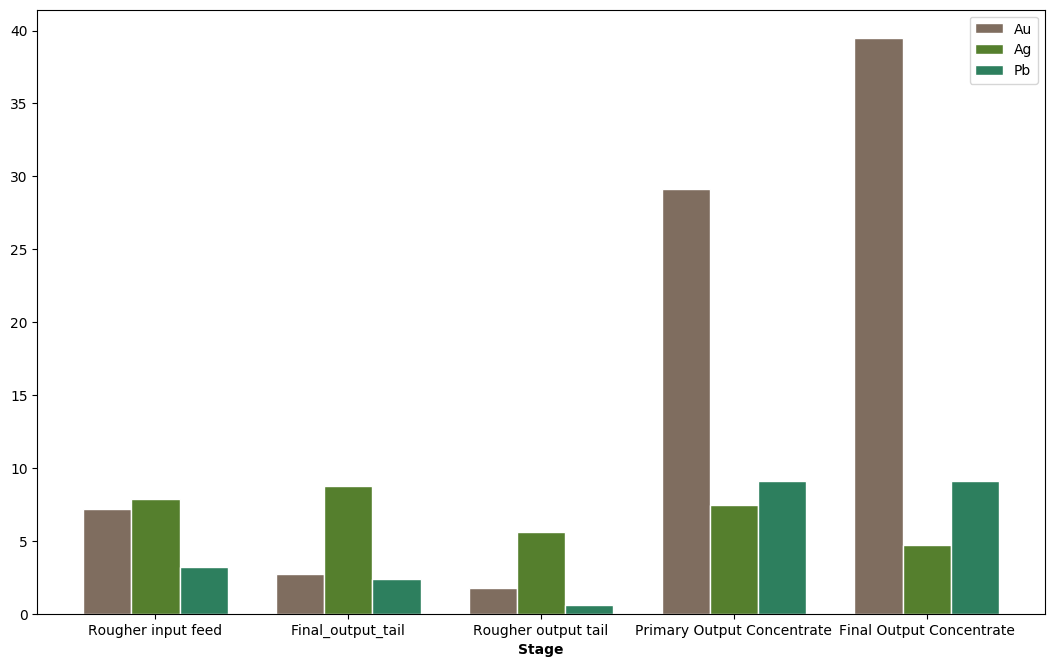

In [11]:

plt.figure(figsize=(13,8), dpi= 100, facecolor='w', edgecolor='k')
labels = ['Au', 'Ag', 'Pb']
bars1 = [au_rougher_feed_input, au_final_output_tail,au_rougher_output_tail, au_primary_output_concentrate, au_final_output_concentrate]
bars2 = [ag_rougher_feed_input, ag_final_output_tail,ag_rougher_output_tail, ag_primary_output_concentrate, ag_final_output_concentrate]
bars3 = [pb_rougher_feed_input, pb_final_output_tail,pb_rougher_output_tail, pb_primary_output_concentrate, pb_final_output_concentrate]

barWidth = 0.25

r1 = np.arange(len(bars1))
r2 = [x + barWidth for x in r1]
r3 = [x + barWidth for x in r2]
 
# Make the plot
plt.bar(r1, bars1, color='#7f6d5f', width=barWidth, edgecolor='white', label='Au')
plt.bar(r2, bars2, color='#557f2d', width=barWidth, edgecolor='white', label='Ag')
plt.bar(r3, bars3, color='#2d7f5e', width=barWidth, edgecolor='white', label='Pb')
 
# Add xticks on the middle of the group bars
plt.xlabel('Stage', fontweight='bold')
plt.xticks([r + barWidth for r in range(len(bars1))], ['Rougher input feed', 'Final_output_tail', 'Rougher output tail','Primary Output Concentrate', 'Final Output Concentrate'])
 
# Create legend & Show graphic
plt.legend()
plt.show()



<div class="alert alert-success">
    Cool, now we know that the process is working as expected!
</div>

The above graph gives us a very direct sense of the concentration of each metal at each stage. As we can see, the concentration of gold greatly increases compared to the input stage. The concentration of Pb also increases, but not as much. Meanwhile, the concentration of Ag actually decreases.
### Compare the feed particle size distributions in the training set and in the test set. If the distributions vary significantly, the model evaluation will be incorrect.

count    16443.000000
mean        58.676444
std         23.922591
min          9.659576
25%         47.575879
50%         54.104257
75%         65.051064
max        484.967466
Name: rougher.input.feed_size, dtype: float64
count    5834.000000
mean       55.937535
std        22.724254
min         0.046369
25%        43.890852
50%        50.002004
75%        61.638434
max       477.445473
Name: rougher.input.feed_size, dtype: float64


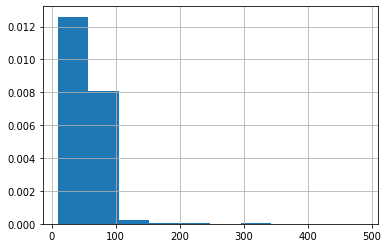

In [12]:
print(train['rougher.input.feed_size'].describe())
print(test['rougher.input.feed_size'].describe())
train['rougher.input.feed_size'].hist(density=True)


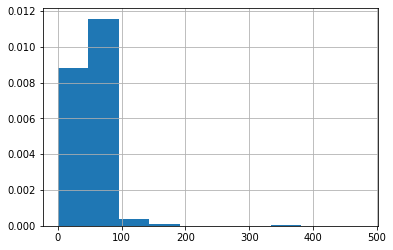

In [13]:
test['rougher.input.feed_size'].hist(density=True)

['rougher.input.feed_ag', 'rougher.input.feed_pb', 'rougher.input.feed_rate', 'rougher.input.feed_size', 'rougher.input.feed_sol', 'rougher.input.feed_au']


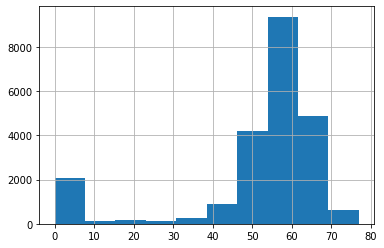

In [14]:
rougher_names = concentrate_sum(full, 'rougher.input.feed_rate', 'rougher.input.feed_size')
full[rougher_names].sum(1).hist()
rougher = full[rougher_names]
#Let us remove rows with only 0
a_series = (rougher != 0).any(axis=1)

rougher = rougher.loc[a_series]




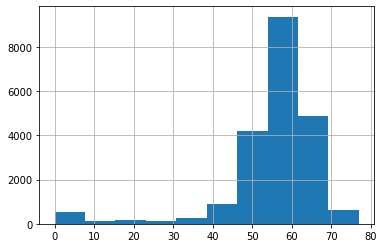

In [15]:
rougher.sum(1).hist()

['rougher.output.concentrate_ag', 'rougher.output.concentrate_pb', 'rougher.output.concentrate_sol', 'rougher.output.concentrate_au']


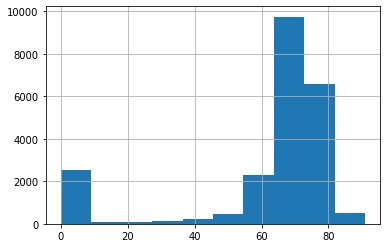

In [16]:
rougher_output_names = cols_with_str(full,'rougher.output.concentrate').columns
full[rougher_output_names].sum(1).hist()

rougher_output = full[rougher_output_names]
#Let us remove rows with only 0
a_series = (rougher_output != 0).any(axis=1)

rougher_output = rougher_output.loc[a_series]

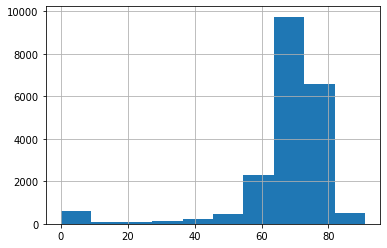

In [17]:
rougher_output.sum(1).hist()

['final.output.concentrate_ag', 'final.output.concentrate_pb', 'final.output.concentrate_sol', 'final.output.concentrate_au']


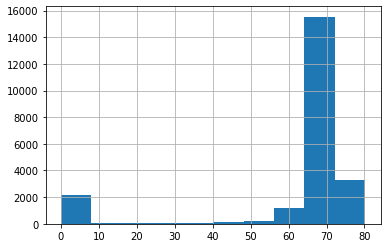

In [18]:
final_output_names = cols_with_str(full,'final.output.concentrate').columns
full[final_output_names].sum(1).hist()

In [19]:
final_output = full[final_output_names]
#Let us remove rows with only 0
a_series = (final_output != 0).any(axis=1)

final_output = final_output.loc[a_series]

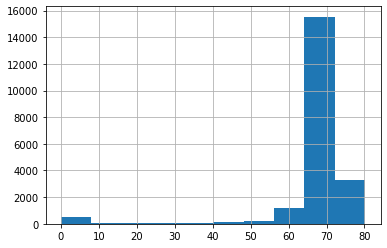

In [20]:
final_output.sum(1).hist()

<div class="alert alert-success">
    Distributions seem similar enough 
</div>

Above, we plotted histograms before and after letting the null value rows stay. It made noticeable differences, hopefully this is good enough for the model.
## Build the model
### Write a function to calculate the final sMAPE value.
The function has been written in the helper functions section of this notebook.

### Train different models. Evaluate them using cross-validation. Pick the best model and test it using the test sample. Provide findings.

To solve the problem, we will need a new metric. It is called sMAPE, symmetric Mean Absolute Percentage Error.
It is similar to MAE, but is expressed in relative values instead of absolute ones. Why is it symmetrical? It equally takes into account the scale of both the target and the prediction.

We will train linear regression, decision tree and random forest models. We will also do a dummy regression to see how the models compare to a baseline.

<div class="alert alert-success">
    SMAPE calculation function is correct!
</div>

In [21]:
target = ['rougher.output.recovery', 'final.output.recovery']
features = list(set(train.columns).intersection(set(test.columns)).difference(set(target)))

#date is not going to be a useful feature, so let's remove it
features.remove('date')

#Before we go further, we have to remember that the target variables are not in our test dataset. Let's use the full
#data to put it in the test data.

test = test.merge(full[['final.output.recovery', 'rougher.output.recovery']], how='left', left_index=True, right_index=True)
train = train.dropna()
test = test.dropna()


In [22]:
features_train, features_test = train[features].values, test[features].values
target_train, target_test = train[target].values, test[target].values

In [23]:
smape_scorer = make_scorer(smape)

lin_reg(features_train, features_test, target_train, target_test)

average smape: 0.0650789851831256
R2 -0.5172570703554005
RMSE: 14.874127394540734
Average Volume of Predicted Reserve: 76.68175317770175


/opt/conda/lib/python3.7/site-packages/sklearn/base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


In [ ]:
dec_tree_mod(features_train, features_test, target_train, target_test)

DecisionTreeRegressor(criterion='mse', max_depth=10, max_features=None,
                      max_leaf_nodes=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      presort=False, random_state=12345, splitter='best')


In [ ]:
rand_for_mod(features_train, features_test, target_train, target_test)

In [ ]:
dum_reg(features_train, features_test, target_train, target_test)


<div class="alert alert-success">
    The modelling section is excellent! You tried several models, tuned their hyperparameters using correct cross-validation.
</div>

## Conclusions
Linear regression had an smape score of 0.65. Decision tree had an smape score of  0.061 with hyperparameter values max_depth = 10. Random forest regression had had an smape score of 0.066 with hyperparameter values max_depth = 9 and n_estimators = 1.

None of these performed as good as the DummyRegressor, which had an smape score of 0.44. Which is surprising considering that the other ML algorithms are designed to solve problems better than the constant model and also because we searched over such a large parameter space. 

The other surprsising thing was that n_estimators was found to give the best result for a value of 1. This means that our Random Forest essentially simplifies to a decision tree.

If the company has more computational power at it's disposal, I would recommend evaluating the performance of these algorithms across a larger parameter space, since even creating the random forest regressor with these parameter search values took me at least 15 minutes.

<div class="alert alert-success">
    Yeah, well, it's important to realize that machine learning models are not always worthwhile. You did good anyway!
</div>